In [1]:
import numpy as np
from numpy import sqrt
import matplotlib.pyplot as py
import getdist as gs
import os
import copy
from getdist import plots, loadMCSamples
from pathlib import Path

First I will define the dynamics

In [2]:
def vect(x, y, V0, m):
    xdot = y
    ydot = -((3)**0.5)*y*(0.5*(y**2) + V0*(x**m))**0.5 - m*(x**(m-1))*V0
    return xdot, ydot

Users may find the following plot, and information in the disseration associated with this notebook, helpful in choosing appropriate parameters

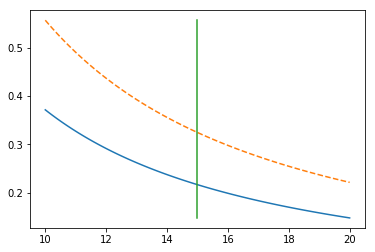

In [3]:
h60 = 2
m = 4/3
linechoice = 15

phi60 = np.linspace(10, 20, 101)
Vzero = [(h60**2)*2/(phi**m) for phi in phi60]
Vzero2 = [(h60**2)*3/(phi**m) for phi in phi60]

py.plot(phi60, Vzero)
py.plot(phi60, Vzero2, '--')
py.plot(np.linspace(linechoice, linechoice, 11), np.linspace(Vzero[-1], Vzero2[0], 11))

The streamplot function doesn't much appreciate small numbers, so we scale $H_0 \rightarrow H_0 \times 10^5 = \tilde{H_0}$, $V_0 \rightarrow V_0 \times 10^{10} = \tilde{V_0}$

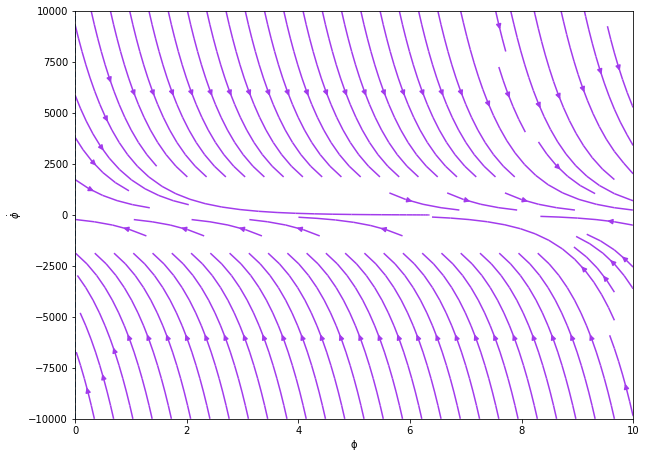

In [4]:
V0 = 0.2
m = 4/3
xbound = 10
ybound = 10000
nx, ny = 1024, 1024
x = np.linspace(0, xbound, nx)
y = np.linspace(-ybound, ybound, ny)
X, Y = np.meshgrid(x, y)

figgy_pud = py.figure(figsize=(10, 7.5)) 
py.streamplot(X, Y, vect(X, Y, V0, m)[0], vect(X, Y, V0, m)[1], density=1, linewidth=None, color='#A23BEC')
py.xlabel('ϕ')
py.ylabel('$\dot{ϕ̇}$')
py.plot(np.zeros(101), np.linspace(-ybound, ybound, 101), '--')

We will consider mapping curves in this plane to curves in the $n_s - r$ plane and conversely

In [6]:
#paths are written as the following
pathbase = "C:/Users/Jacob/Documents/aWarwicka/4y_project/Python_tasks/Getdist/base_r/plikHM_TTTEEE_lowl_lowE"
dirs = os.listdir(pathbase)
#os.listdir returns a list of strings
basepth = "C:/Users/Jacob/Documents/aWarwicka/4y_project/Python_tasks/Getdist/base_r/plikHM_TTTEEE_lowl_lowE"
root = "base_r_plikHM_TTTEEE_lowl_lowE"

samps = loadMCSamples(os.path.join(basepth, root), settings={'ignore_rows':0.3})

We can generate $(n_s, r)$ points from the data chains in file `plikHM_TTTEEE_lowl_lowE`

numpy.ndarray

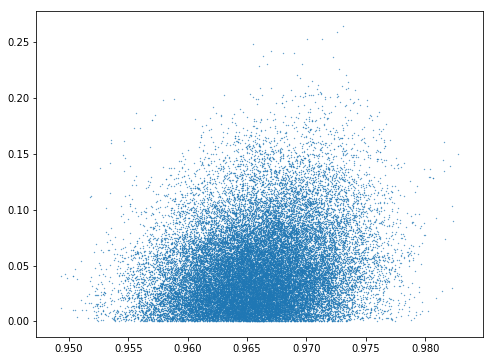

In [7]:
sampscopy = copy.deepcopy(samps)
params = samps.getParams()
g = plots.get_single_plotter(chain_dir=Path(basepth), width_inch=8)
py.scatter(params.ns, params.r, s = 0.1)
type(params.ns)

((0.948708516491897, 0.9825523835081029), (0.0, 0.22283271483775025))

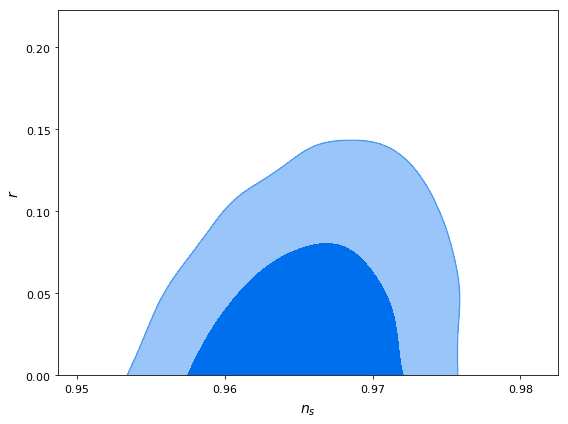

In [8]:
g = plots.get_single_plotter(chain_dir=Path(basepth), width_inch=8)
g.plot_2d(samps,'ns', 'r', filled=True)

Let's add the $H$ trajectory data to the plot

In [9]:
#Some often used functions go first
grad_calc = lambda H, V0, phi, m: (abs(1.5*(H**2) - 0.5*V0*(phi**m)))**0.5
grad_sqr = lambda H, V0, phi, m: 1.5*(H**2) - 0.5*V0*(phi**m)
epsilon_calc = lambda  H, V0, phi, m: 2*(abs(1.5*(H**2) - 0.5*V0*(phi**m))/(H**2))
def f(H, V0, phi, m):
    '''Interpolation of step-size so that particularly small ε values have small enough step sizes. 
    This could be particularly helpful with ϕ^m potentials for small m>0'''
    returnval = (0.5**((0.0001/epsilon_calc(H, V0, phi, m)))) if epsilon_calc(H, V0, phi, m) < 0.0001 else 0.5
    return returnval

In [10]:
def trajectory(V_0, m, phi_0, dphi0 = 0.0001, boundmultiplier = 100, H0 = 2, suppress = False):
    '''The first stage is to integrate forwards in time, to the end of inflation. We use and RK4 adaptive-step integrator,
    but the step size adapts according to ε rather than some error estimate.'''
    #
    #We check whether the initial point is in the right domain
    #
    if not (3*(H0**2)/((phi_0)**m) > V_0 > 2*(H0**2)/((phi_0)**m) or suppress):
        raise Exception("wrong parameter choice")
    #Initialise some zero arrays - we choose the maximal size dependent on the initial ϕ, initial step size (so to fit in a weak lower bound
    #number of steps before ϕ = 0) and an input 'boundmultiplier' default 100
    #
    T =  int(phi_0/dphi0)
    phi = np.zeros(boundmultiplier*T+1)  #adapting ϕ mesh
    H = np.zeros(boundmultiplier*T+1) #H values
    phi[0] = phi_0 #initial ϕ
    H[0]  = H0 #initial H
    epsilon = epsilon_calc(H[0], V_0, phi[0], m) #initial epsilon
    #
    n = 0
    dphi = dphi0
    #SPACE
    while (epsilon < 1) and (n < boundmultiplier*T):
        #Here we make successive gradient estimates, as per RK integration, using grad_calc to calculate the gradient at a point
        #
        K1 = grad_calc(H[n], V_0, phi[n], m)
        K2 = grad_calc(H[n] - 0.5*dphi*K1, V_0, phi[n] - 0.5*dphi, m)
        K3 = grad_calc(H[n] - 0.5*dphi*K2, V_0, phi[n] - 0.5*dphi, m)
        K4 = grad_calc(H[n] - dphi*K3, V_0, phi[n] - dphi, m)
        grad = (K1 + 2*K2 + 2*K3 + K4)/6
        #Currently, we are moving forwards in time, corresponding to decreasing ϕ
        #
        H[n+1] = H[n] - dphi*grad
        phi[n+1] = phi[n] - dphi
        epsilon = epsilon_calc(H[n+1], V_0, phi[n+1], m)
        coeff = f(H[n+1], V_0, phi[n+1], m)
        #Here, we change dphi so that its new value would not make it cross the ε = 0 contour, and our choice of coefficient hopefully ensures
        #that it doesn't cross the separatrix for this potential
        #
        dphi = min(coeff*(H[n+1] - ((V_0*(phi[n+1])**m)*(1/3))**0.5)/(grad_calc(H[n+1], V_0, phi[n+1], m)), dphi0)
        n += 1
    return phi[0:n+1], H[0:n+1], n, epsilon #after the nth value of phi, H (if such exists) the values are the initial, meaningless zero values

def tot_traj(Nstart, V_0, m, phi_0 = 15, dphi0 = 0.0001, boundmultiplier = 100, H0 = 2, suppress = False, epsilonstop = False):
    '''This function takes a solution from    trajectory()   , parametrises it by N, and integrates backwards (parametrising by N) to achieve
    a piece of the trajectory corresponding to earlier times'''
    T = int(phi_0/dphi0)
    gradpositive = True #to be explained
    phiswap, Jswap, n0, epsilon = trajectory(V_0, m, phi_0, dphi0, boundmultiplier, H0, suppress)
    #
    #swap order of phi array and H array - we are about to integrate backwards in time
    phi1, J1 = phiswap[::-1], Jswap[::-1]
    #
    #W start at the end of inflation, so we start at N = 0
    #Initialise arrays to bound the memory we will need
    N = np.zeros(boundmultiplier*T + 1)
    phi = np.zeros(boundmultiplier*T + 1)
    H = np.zeros(boundmultiplier*T + 1)
    ε = np.zeros(boundmultiplier*T + 1)
    #we have our phi values up to phi_0 and the corresponding H values already
    phi[:n0 + 1] = phi1
    H[:n0 + 1] = J1
    #assign epsilon at the start of the scheme, the end of infaltion
    ε[0] = epsilon
    #Initialise number of steps n
    n = 0
    n_sgn_change = boundmultiplier*T + 1
    while (N[n] < Nstart) and (n < n0):
        #Here we are just reparametrising the H trjectory we already have
        dphi = phi[n+1] - phi[n]
        ε[n+1] = epsilon_calc(H[n+1], V_0, phi[n+1], m)
        #
        #we have what is effectively an RK2 scheme here - the error at each step of this loop is not intrinsically dependent
        #on the error of earlier steps, so there isn't as much reason to choose a high order integrator here as there is in
        #integrating the HJ equation
        #
        E1 = (2 / ε[n])**0.5
        E2 = (2 / ε[n+1])**0.5
        N[n+1] = N[n] + dphi*(E1 + E2)/4
        n += 1
    #
    #
    '''Next we make a series of checks:
    
    - (gradpositive = True) tells is that the standard scheme predicts sensible H', so we can continue as before
    
    -The (N < Nstart) check puts a time limit on the time span we consider; the scheme should stop at N = Nstart
    
    -A very large upper bound is chosen, linear in each of    boundmultiplier   and    phi_0
    
    -Inflation should not occur for ε > 1, so the default setting is that too large an ε will end the scheme, but by
    setting   (epsilonstop = False)   backwards integration will continue past this point'''
    #
    #
    while gradpositive and (N[n] < Nstart) and (n < boundmultiplier*T) and (ε[n] < 1 or not epsilonstop):
        while (N[n] < Nstart) and (n < boundmultiplier*T) and (ε[n] < 1 or not epsilonstop):
            #
            #The next check allows us to skip time-consuming checks if epsilon is clearly still not close to zero. In the unlikely case of
            #fatal errors, increasing the lower bound of the below epsilon check may help
            #
            if ε[n] > 0.001:
                dphi = min(0.5*(H[n] - ((V_0*(phi[n])**m)*(1/3))**0.5)/(grad_calc(H[n], V_0, phi[n], m)), dphi0)
                #RK4 section
                #
                K1 = grad_calc(H[n], V_0, phi[n], m)
                K2 = grad_calc(H[n] + 0.5*dphi*K1, V_0, phi[n] + 0.5*dphi, m)
                K3 = grad_calc(H[n] + 0.5*dphi*K2, V_0, phi[n] + 0.5*dphi, m)
                K4 = grad_calc(H[n] + dphi*K3, V_0, phi[n] + dphi, m)
                grad = (K1 + 2*K2 + 2*K3 + K4)/6
                H[n+1] = H[n] + dphi*grad
                phi[n+1] = phi[n] + dphi
                #
                ε[n+1] = epsilon_calc(H[n+1], V_0, phi[n+1], m)
                #
                #RK2 section
                #
                E1 = (2 / ε[n])**0.5
                E2 = (2 / ε[n+1])**0.5
                N[n+1] = N[n] + dphi*(E1 + E2)/4
                n += 1
            else:
               #At this stage, ε has become very small. We check at each stage whether we are going to pass phidot = 0, in which case we note this
                #and continue so that we may return to assume a change in sign
                coeff = f(H[n], V_0, phi[n], m)
                dphi = min(coeff*(H[n] - ((V_0*(phi[n])**m)*(1/3))**0.5)/(grad_calc(H[n], V_0, phi[n], m)), dphi0)
                #
                #We check whether the next gradient estimate corresponds to H' > 0. If so, we may proceed (and check the same for the other
                #gradient estimates), but as soon as a negative estimate is made we note this and will change the integrator
                if grad_sqr(H[n], V_0, phi[n], m) > 0:
                    K1 = grad_calc(H[n], V_0, phi[n], m)
                else:
                    gradpositive = False
                    break
                if grad_sqr(H[n] + 0.5*dphi*K1, V_0, phi[n] + 0.5*dphi, m):
                    K2 = grad_calc(H[n] + 0.5*dphi*K1, V_0, phi[n] + 0.5*dphi, m)
                else:
                    gradpositive = False
                    break
                if grad_sqr(H[n] + 0.5*dphi*K2, V_0, phi[n] + 0.5*dphi, m):
                    K3 = grad_calc(H[n] + 0.5*dphi*K2, V_0, phi[n] + 0.5*dphi, m)
                else:
                    gradpositive = False
                    break
                if grad_sqr(H[n] + dphi*K3, V_0, phi[n] + dphi, m):
                    K4 = grad_calc(H[n] + dphi*K3, V_0, phi[n] + dphi, m)
                else:
                    gradpositive = False
                    break
                grad = (K1 + 2*K2 + 2*K3 + K4)/6
                H[n+1] = H[n] + dphi*grad
                phi[n+1] = phi[n] + dphi
                ε[n+1] = epsilon_calc(H[n+1], V_0, phi[n+1], m)
                #SPACE
                J1 = (2 / ε[n])**0.5
                J2 = (2 / ε[n+1])**0.5
                N[n+1] = N[n] + dphi*(J1 + J2)/4
                n += 1
     #
    #once we note the unavoidable change in sign is imminent, we approximate phi constant, H' takes the negative of its last value,
    #so H is unchanged - see the associated dissertation for justification
    #
    if (N[n] < Nstart) and (n < boundmultiplier*T) and (ε[n] < 1 or not epsilonstop):
        H[n] = H[n-1]
        phi[n] = phi[n-1]
        ε[n] = ε[n - 1]
        #
        #Record the index when the sign of H' changes
        n_sgn_change = n
        #
        #Calculate the number of e-folds passed, as per the associated dissertation
        N[n] = N[n-1] + (4*grad_calc(H[n-1], V_0, phi[n-1], m)*((V_0*(phi[n-1])**m)**0.5))/((3**0.5)*((m*V_0*(phi[n-1])**(m-1))**0.5))
        #
        #In this final loop, we take the equivalent of dphi -> -dphi, H' takes negative square root
        #
    while (N[n] < Nstart) and (n < boundmultiplier*T) and (ε[n] < 1 or not epsilonstop):
        #step size
        dphi = min(0.5*(H[n] - ((V_0*(phi[n])**m)*(1/3))**0.5)/(grad_calc(H[n], V_0, phi[n], m)), dphi0)
        #
        #RK4
        #
        K1 = -grad_calc(H[n], V_0, phi[n], m)
        K2 = -grad_calc(H[n] + 0.5*dphi*K1, V_0, phi[n] + 0.5*dphi, m)
        K3 = -grad_calc(H[n] + 0.5*dphi*K2, V_0, phi[n] + 0.5*dphi, m)
        K4 = -grad_calc(H[n] + dphi*K3, V_0, phi[n] + dphi, m)
        grad = (K1 + 2*K2 + 2*K3 + K4)/6
        H[n+1] = H[n] - dphi*grad
        phi[n+1] = phi[n] - dphi
        #
        ε[n+1] = epsilon_calc(H[n+1], V_0, phi[n+1], m)
        #
        #RK2
        #
        E1 = (2 / ε[n])**0.5
        E2 = (2 / ε[n+1])**0.5
        N[n+1] = N[n] + dphi*(E1 + E2)/4
        #
        n += 1
    return phi[:n+1], H[:n+1], n, ε[:n+1], N[:n+1], n_sgn_change

phi1 = lambda C, r0, m: 8*sqrt(2)*(r0 - 48)*m/(sqrt(r0)*(C*r0 - 16*C - r0 - 176)) #map gives phi values implied by likely r and n_s values
phidot1 = lambda C, r0, m, V0: (V0**0.5)*sqrt(-2*(r0 - 48)*((8*sqrt(2)*(r0 - 48)*m/(sqrt(r0)*(C*r0 - 16*C - r0 - 176)))**m)*r0)/(r0 - 48)

It is clear that what we must do now is get a function which turns $r$ and $n_s$ values into $\phi$, $\dot{\phi}$

(0, 15)

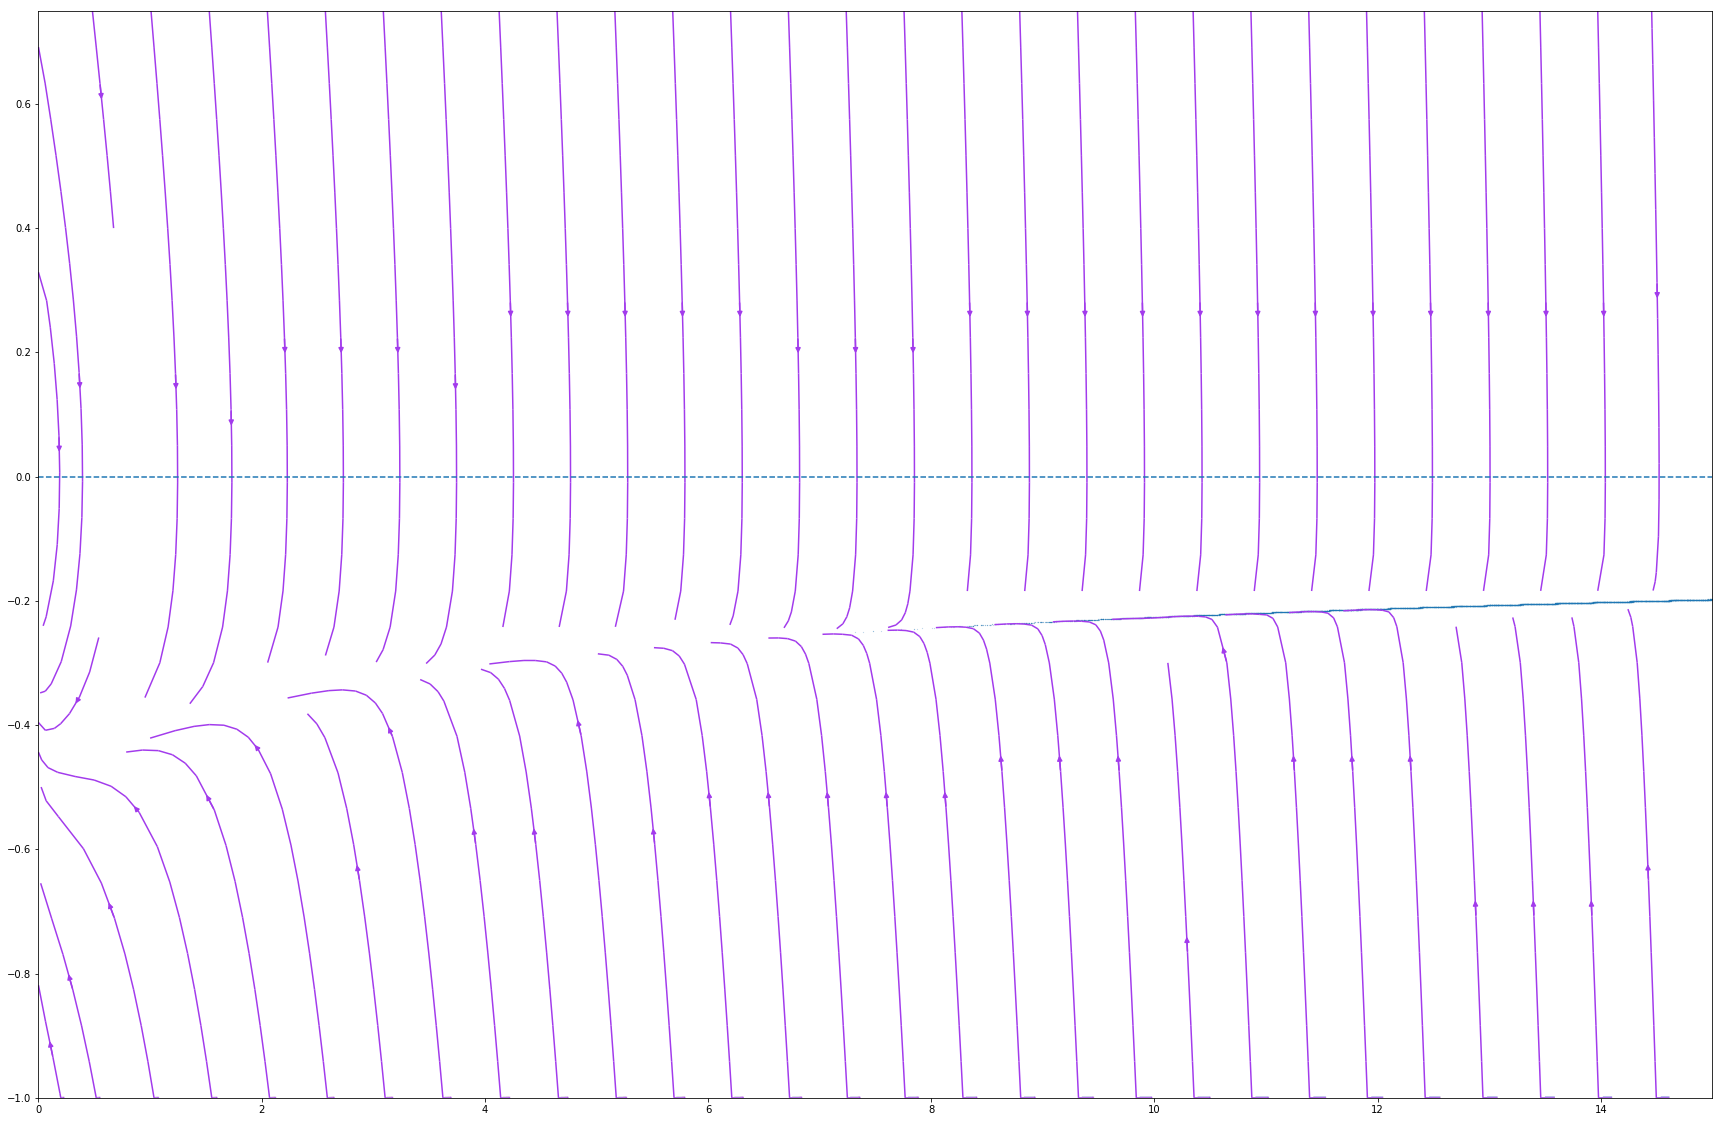

In [11]:
kchoice = 4/3
V0choice = 0.4
initphi = 15

xbound = 15
ybound = 1
nx, ny = 1024, 1024
x = np.linspace(0, xbound, nx)
y = np.linspace(-ybound, 0.75*ybound, ny)
X, Y = np.meshgrid(x, y)

plane = py.figure(figsize=(30, 20)) 
py.streamplot(X, Y, vect(X, Y, V0choice, kchoice)[0], vect(X, Y, V0choice, kchoice)[1], density=1.0, linewidth=None, color='#A23BEC')
py.plot(np.linspace(0, xbound, 101), np.zeros(101), '--')

        
phi1_scatter = [phi1(ns, r, 4/3) for [ns, r] in zip(params.ns, params.r)]
phidot1_scatter = [phidot1(ns, r, 4/3, V0choice) for [ns, r] in zip(params.ns, params.r)]
py.scatter(phi1_scatter, phidot1_scatter, s = 0.01)
py.xlim([0, 15])

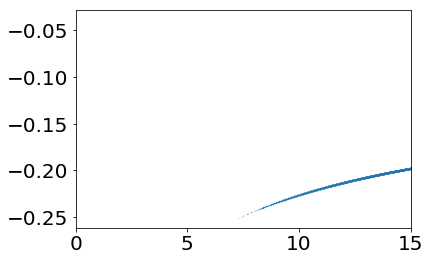

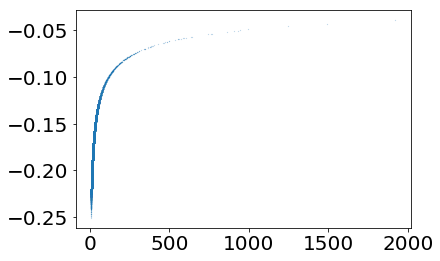

In [13]:
phi1_scatter = [phi1(ns, r, 4/3) for [ns, r] in zip(params.ns, params.r)]
phidot1_scatter = [phidot1(ns, r, 4/3, V0choice) for [ns, r] in zip(params.ns, params.r)]
py.scatter(phi1_scatter, phidot1_scatter, s = 0.01)
py.xlim([0, 15])
py.figure()

py.scatter(phi1_scatter, phidot1_scatter, s = 0.01)

Proportion of data with ϕ < 70 : 0.9690806651092483


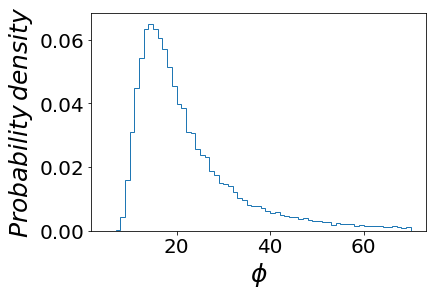

In [48]:
lim = 70
small_list = [n for n in range(5, lim+1)]


histsmall = py.hist(phi1_scatter, small_list, density = True, histtype = 'step')
py.xlabel('$\phi$')
py.ylabel('$Probability\,density$')
py.savefig('ph1marge.png')


proportion = len(list(filter(lambda x: x < lim, phi1_scatter)))/len(phi1_scatter)
print('Proportion of data with ϕ <', lim, ':', proportion)

Proportion of data with -0.28 <φ< -0.1 : 0.9895561357702349


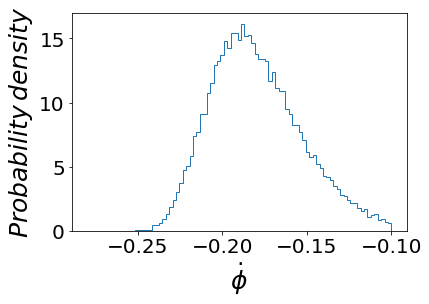

In [59]:
lim_low = -0.28
lim_high = -0.1
small_list = np.linspace(lim_low, lim_high, int((lim_high-lim_low)/0.002))


histsmall = py.hist(phidot1_scatter, small_list, density = True, histtype = 'step')
py.xlabel('$\dot{\phi}$')
py.ylabel('$Probability\,density$')
py.savefig('ph1dotmarge.png')


proportion = len(list(filter(lambda x: lim_low < x < lim_high, phidot1_scatter)))/len(phidot1_scatter)
print('Proportion of data with', lim_low, '<φ<', lim_high, ':', proportion)

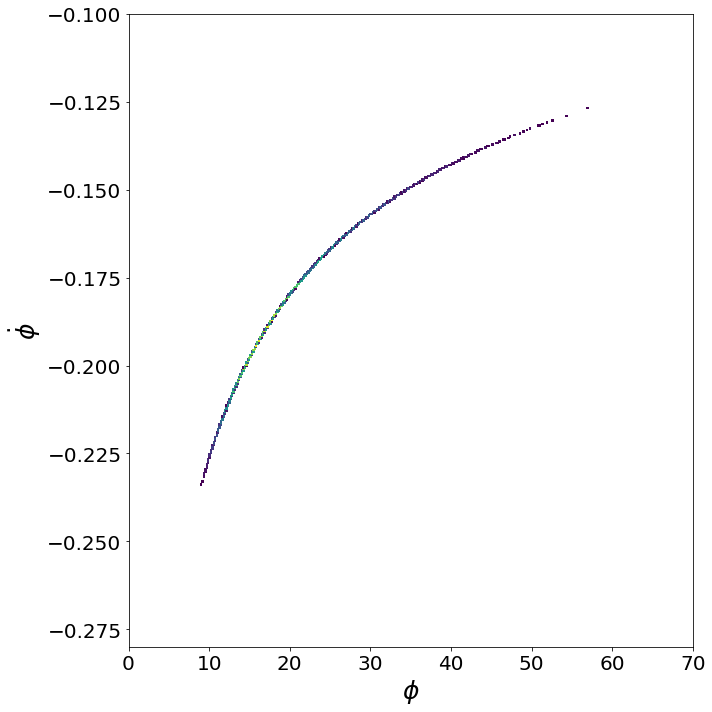

In [61]:
fig, ax = py.subplots(tight_layout=True, figsize = (10, 10))
py.xlabel('$\phi$')
py.ylabel('$\dot{\phi}$')
hist = ax.hist2d(phi1_scatter, phidot1_scatter, bins = 400, range = [[0, lim], [lim_low, lim_high]], cmin = 20)
py.savefig('jointdist.png')